Alan Turing's famous Turning test helps evaulate whether a machine's intelligence matches a human's intelligence. This test was called the imitation game. Where a machine has to try fool the human into thinking it is a human. 

A common approach to language tasks are Recurrent Neural Networks (RNNs), but there are many other types that have other use cases:

- Character RNN used to predict the next character in an sentence, using a Stateless RNN and then a Stateful RNN.
- Sentiment Analysis by extracting a feeling within a sentence
- Neural Machine Translation (NMT) capable of tranlating languages. 

We will also look at how we can boost the RNN performance by using Attention Mechanisms and Encoder-Decoder architecture, which allows the network to focus on a select part of the inputs at each time step. 

Finally, we will then look at a Transformer, a very succesful NLP architecture, before discussing GPT-2 and BERT. 

In [1]:
import sys 
sys.version_info > (3, 5)

import numpy as np
import tensorflow as tf
assert tf.__version__ > "2.0"
from tensorflow import keras
import matplotlib.pyplot as plt

# Shakespeare Dataset

Below is an example of how we would work with text data by converting it using a tokenizer, how to split text data because we cannot shuffle the data as we do with tabular data, 

In [2]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [3]:
print(shakespeare_text[60:250])



All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [4]:
"".join(sorted(set(shakespeare_text.lower()))) # list of characters within dataset

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

## Tokenize Text data

In [5]:
# convert all characters into a unique character ID
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [6]:
tokenizer.texts_to_sequences('Romeo')

[[9], [4], [15], [2], [4]]

In [7]:
"".join(tokenizer.sequences_to_texts([[9], [4], [15], [2], [4]]))

'romeo'

In [8]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count

Note, the word encoder sets the IDs from 1 to 39 so when we convert the entire text to ID we need to subtract 1 so we can get IDs from 0 to 38.


In [9]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

Before we talk about how we can split the text data into training, validation and test set, lets first talk about how we can split the time series data.

##### Splitting Time series data

The safest way is to split the data up across time. For example, take the years 2000 to 2016 as the training, 2017 to 2019 as the validation and leaving 2020 to 2021 as the test set. Ensure there is no overlap in the sets. 

There are two problems: correlation between time series data and assuming your data is a stationary. 
- **Correlation** between variables can lead to an optimisitically biased generalization error, because the training and test set, both contain time series data which are correlated. In these scenarios we should avoid having correlated time series across the training and test set.s

- Assuming that your data is a **Stationary** time series (i.e. the mean, variance and autocorrelation does not change). This assumption works well for most time series data but some time series data has disappearing patterns over time. In these scenarios we would benefit by training the data on short time spans. You can plot the model's error on the validation set, and if you observe increasing errors towards the end of the data then you know the data is not stationary enough.

For example, if you have financial data for many companies, some companies are well correlated because of the sectors that they are in. Traders would exploit these correlations once they realise it, however patterns may soon disappear because of it. The correlation, alongside the unstationary nature, of the data prevents us from obtaining a generalizable model.

Ultimately, how you split time series data depends on the task at hand. 




## Splitting Sequential Text data

Splitting text data is pretty simple, in that we must have no overlap between the sets and introduce a gap to avoid paragraph overlapping. 

In [10]:
train_size = dataset_size * 90 // 100 # take 90% of the data and // 100 to get steps of 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

The `dataset` now is a single sequence of over one million characters. Recall how RNNs work on the previous notebook. If we were to train the neural network it would be equivalent to training a deep neural network with over a million layers - with only one (very long) instance!

Instead, we need to convert this dataset into smaller windows of text. The length of the window size is the maximum pattern length the RNN will learn. The RNN will unrolled over the length of the substrings, this is called **Truncated Backpropagation Through Time (TBPTT)**. Read [this](https://www.quora.com/Whats-the-key-difference-between-backprop-and-truncated-backprop-through-time) Quora answer to understand the difference between backpropagation through time and truncated.


In [11]:
n_steps = 100
window_length = n_steps + 1
dataset = dataset.window(size=window_length, shift=1, drop_remainder=True)

The `shift` argument causes the difference between the next window to be 1 character. For example, the first window will be 0 to 100 the next will be 1 to 101 etc.. Setting the `drop_remainder=True` argument makes every window size equal to `size` argument. Otherwise, the last windows will go from 100 to 1 characters in length. 

In [12]:
dataset # datasets within a dataset

<WindowDataset shapes: DatasetSpec(TensorSpec(shape=(), dtype=tf.int64, name=None), TensorShape([])), types: DatasetSpec(TensorSpec(shape=(), dtype=tf.int64, name=None), TensorShape([]))>

In [13]:
# we now need to flatten it, as the model only accepts tensors
dataset = dataset.flat_map(lambda window: window.batch(window_length))

# the flat_map function flattens the dataset
# the lambda function forces it to create tensors of window_size length

# for example, if 
# example = {{1, 2}, {3, 4, 6, 7}, {8, 9, 10}}
# then example.flat_map(lambda eg: eg.batch(2)), would become
# {{1, 2}, {3, 4}, {5, 6}, {7, 8}, {9, 10}}

Now that the dataset is in the right shape we can shuffle these windows so that gradient descent can have instances that are indepenedent and identically distributed across the training set. 

In [14]:
batch_size = 32
dataset = dataset.shuffle(10000, seed=42).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:])) # X, y

In [15]:
z = [1, 2, 3, 4, 5]
(z[: -1], z[1: ]) # we are trying to predict the next window size

([1, 2, 3, 4], [2, 3, 4, 5])

In [16]:
# one hot encode the dataset as there are not many unique characters ~ 39
dataset = dataset.map(
    lambda X_batch, y_batch: (tf.one_hot(X_batch, depth=max_id), y_batch))

# calling prefetch allows later elements to be prepared while the current element is being processed
dataset = dataset.prefetch(1)

In [17]:
for X_batch, y_batch in dataset.take(1):
  print(X_batch.shape, y_batch.shape)

(32, 100, 39) (32, 100)


## Build Model - Char RNN

We can train a model on all of Shakespeare's work and then use it to predict a character in a sentence. This can be used to produce novel text and is pretty fun to read about. 

Read this blog by Andrej Karapthy: https://karpathy.github.io/2015/05/21/rnn-effectiveness/

In [18]:
model = keras.models.Sequential([
  keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id], 
                   dropout=0.2,), # recurrent_dropout=0.2), #  prevents GPU support
  keras.layers.GRU(128, return_sequences=True,
                   dropout=0.2,), # recurrent_dropout=0.2), #  prevents GPU support
  keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation='softmax'))
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.fit(dataset, epochs=1) #5) #  this cell will take a long time to run!

31368/31368 [==============================] - 6345s 202ms/step - loss: 1.6169


## Make Predictions

In [19]:
def preprocess(texts):
  """
  Function that preprocesses text data and returns one hot encoded data. 
  """
  X = np.array(tokenizer.texts_to_sequences(texts)) - 1
  return tf.one_hot(X, max_id)

X_new = preprocess(['great new'])
Y_pred = np.argmax(model(X_new), axis=-1)
print(tokenizer.sequences_to_texts(Y_pred + 1)[0][-1]) # print first sentence last character

s


Although, this is amusing and satisifying to have predicted the next character this does not work well in practice because the model would repeat the same works over and over again.

Instead, we can pick the next letter randomly which will generate diverse and interesting text. We can use the `tf.random.categorical` function, which takes in logits divided by a hyperparameter, temperature. Lower values favour high probability characters while high values will give characters an equal probability. 

The model is ok for small data but if we wanted to realise patterns over a large time step, you can use Stateful RNNs.

# Stateful RNN

So far we have trained Stateless RNNs, this is where at each iteration the model starts with hidden state full of zeros and updates them at the end of each time step. It then removes them at the last time step.

![Stateless vs Stateful](https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-27947-9_24/MediaObjects/480892_1_En_24_Fig3_HTML.png)

Stateful RNNs reuse the state between batches instead of reinitializing them. This can allow the model to learn long term patterns.

One thing we need to change about the input dataset when using Stateful RNNs is not to split the batches up so that one batch starts where the previous batch left off. There should be no overlap like we saw with the `windows()` function earlier. Stateful RNNs require sequential and non-overlapping input sequences.

Unfortnately, this is not easy to do and requires a lot of code. 

In [20]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size) # split into 32 parts
# len(encoded_parts) = 32 

datasets = []
n_steps = 100
window_length = n_steps + 1

for encoded_part in encoded_parts:
  dataset = tf.data.Dataset.from_tensor_slices(encoded_part) # dataset object
  dataset = dataset.window(window_length, shift=n_steps,
                           drop_remainder=True) # flatten windows
  dataset = dataset.flat_map(lambda window: (window.batch(window_length)))
  datasets.append(dataset)


dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows)) # create one massive dataset
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

Make sure you specify `stateful=True` and the `batch_input_shape`, this is so tensorflow can preserve a state for each input sequenence in the batch. 

In [21]:
model = keras.models.Sequential([
  keras.layers.GRU(128, return_sequences = True, stateful = True,
                   dropout = 0.2, # recurrent_dropout=0.2,
                   batch_input_shape = [batch_size, None, max_id]),
  keras.layers.GRU(128, return_sequences = True, stateful = True,
                   dropout = 0.2),
  keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation='softmax'))
])

In [22]:
class ResetStatesCallback(keras.callbacks.Callback):
  """
  Callback used in Stateful RNN model, to reset states at the end of each
  epoch.
  """
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

In [23]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.fit(dataset, epochs=1, callbacks=[ResetStatesCallback()])

313/313 [==============================] - 63s 190ms/step - loss: 2.6158


# Sentiment Analysis

Sentiment Analysis is when you classifiy a piece of text as either positive (1) or negative (0). A popular dataset is used, kind of like the "hello world" of sentiment analysis called the IMDB reviews dataset.

In [24]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

17473536/17464789 [==============================] - 0s 0us/step


`keras` provides the preprocessed dataset, where the data has been tokenized per word, punctuations removed, words converted to lowercase and indexed by frequency (low values represent more frequent words).

The integers 0, 1 and 2 are special and represent padding tokens, start of sequence (SSS) token and unknown words. 

In [25]:
word_index = keras.datasets.imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words
inverted_word_index = dict((i+3, word) for (word, i) in word_index.items())

for i, token in enumerate(('<pad>', '<sos>', '<unk>')):
  inverted_word_index[i] = token
# Decode the 3rd sequence in the dataset
decoded_sequence = " ".join(inverted_word_index[i] for i in X_train[4])
decoded_sequence

1654784/1641221 [==============================] - 0s 0us/step


"<sos> worst mistake of my life br br i picked this movie up at target for 5 because i figured hey it's sandler i can get some cheap laughs i was wrong completely wrong mid way through the film all three of my friends were asleep and i was still suffering worst plot worst script worst movie i have ever seen i wanted to hit my head up against a wall for an hour then i'd stop and you know why because it felt damn good upon bashing my head in i stuck that damn movie in the microwave and watched it burn and that felt better than anything else i've ever done it took american psycho army of darkness and kill bill just to get over that crap i hate you sandler for actually going through with this and ruining a whole day of my life"

Looks a like a movie with Adam Sandler in it - pretty funny review, definitely negative. 

Notice that within the review there are characters like `br` and some punctuation has been left in. 

Tokenizing words and splitting them by space boundaries might not work in all situations. There are some words where a space is used but both of them tie in together, for example San Francisco. Fortunately, we can take advantage of many open source tools such as Google's Sentence Piece, Byte Pair Encoding or WordPiece. These tools can help convert text into intgers that can be used in a model.

Instead of using the ready made dataset, lets use the byte string imdb data from tensorflow.

### Load IMDB Reviews

In [26]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAD3R9X/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAD3R9X/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAD3R9X/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [27]:
for X_batch, y_batch in datasets["train"].shuffle(20).batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: Nathan Detroit runs illegal craps games for high rollers in NYC, but the heat is on and he can't find a secure location. He bets chronic gambler Sky Masterson that Sky can't make a prim missionary, Sa ...
Label: 0 = Negative

Review: Finally, Timon and Pumbaa in their own film...<br /><br />'The Lion King 1 1/2: Hakuna Matata' is an irreverent new take on a classic tale. Which classic tale, you ask? Why, 'The Lion King' of course! ...
Label: 1 = Positive



In [28]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [29]:
train_size = info.splits['train'].num_examples
test_size = info.splits['test'].num_examples

### Preprocess data - Encoding

The best thing to do when creating a tensorflow models is to try restrict any preprocessing steps with tensorflow operations only. 

In [30]:
def preprocess(X_batch, y_batch):
  """
  Preprocesses the data and returns a dense tensor
  """
  # 
  X_batch = tf.strings.substr(X_batch, 0, 300) # shorten reviews to speed up processing
  X_batch = tf.strings.regex_replace(X_batch, b"<br\s*/?>", b" ")
  X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z]", b" ")
  X_batch = tf.strings.split(X_batch) #  returns a ragged tensor
  return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [31]:
from collections import Counter

vocabulary = Counter()

# create vocabulary dictionary
for X_batch, y_batch in datasets['train'].batch(32).map(preprocess):
  for review in X_batch:
    vocabulary.update(list(review.numpy()))

In [32]:
len(vocabulary)

49739

That is a total of ~50,000 words. Not all words will be important so lets truncate to the top 10,000 words.

In [33]:
vocabulary.most_common()[:5]

[(b'<pad>', 224494),
 (b'the', 61156),
 (b'a', 38569),
 (b'of', 33984),
 (b'and', 33432)]

In [34]:
vocab_size = 10000
truncated_vocabulary = [word for word, count in vocabulary.most_common()[:vocab_size]]

In [35]:
# tokenize each word 
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(words), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)

# specify the number of out of bucket values
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets=num_oov_buckets)
table

The `oov_buckets` is gives us a margin when the model is passed a word it does not have within the Vocabulary Table. It will simply id that word as 10000, i.e. vocab_size + 1.

In [36]:
def encode_words(X_batch, y_batch):
  """
  Uses a vocabulary table to encode the reviews
  """
  return table.lookup(X_batch), y_batch

train_set = datasets['train'].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

### Train Model

In [37]:
embedding_dimension_size = 128

model = keras.models.Sequential([
  keras.layers.Embedding(input_dim=vocab_size + num_oov_buckets,
                         output_dim=embedding_dimension_size,
                         input_shape=[None], 
                         mask_zero=True), #  ignores padding tokens, i.e. id of 0
  keras.layers.GRU(128, return_sequences=True),
  keras.layers.GRU(128, return_sequences=False),
  keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

model.fit(train_set, epochs=1)

782/782 [==============================] - 149s 180ms/step - loss: 0.5374 - accuracy: 0.7196


The `mask_zero=True` allows the model to ignore the `id=0`, which is typically `<pad>`. If it is not then make it. 


In [38]:
test_set = datasets['test'].batch(32).map(preprocess)
test_set = test_set.map(encode_words).prefetch(1)

In [39]:
model.evaluate(test_set)

782/782 [==============================] - 39s 47ms/step - loss: 0.4723 - accuracy: 0.7721


[0.4722706973552704, 0.7720800042152405]

This is great but having to manually train your own models in a task that is very common like Sentiment Analysis is unreasonable. We can take advantage of tensorflow's pretrained embeddings. 

Embeddings need to be learned but some words like amazing, awesome and fantastic would end up close to one another within the embedded space. Instead of having to relearn this, the pretrained model, on tensorflow, can be used - which is trained on a huge corpus dataset - 7 billion words!



### Reusing Pretrained Embeddings

There are numerous pretrained models on tensorflow [word embeddings](https://www.tensorflow.org/text/guide/word_embeddings). Take a look at TF Hub repository [here](https://tfhub.dev). Browse the models with the repository and just copy the code across to use in your project. 

In [40]:
# load data 
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].batch(batch_size).prefetch(1)

In [41]:
# load pretrained model from tf hub
import tensorflow_hub as hub

model = keras.Sequential([
  hub.KerasLayer('https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1',
                 dtype=tf.string, input_shape=[], output_shape=[50]),
  keras.layers.Dense(128),
  keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 5s 6ms/step - loss: 0.5473 - accuracy: 0.7257
Epoch 2/5
782/782 [==============================] - 5s 6ms/step - loss: 0.5230 - accuracy: 0.7422
Epoch 3/5
782/782 [==============================] - 5s 6ms/step - loss: 0.5220 - accuracy: 0.7424
Epoch 4/5
782/782 [==============================] - 5s 6ms/step - loss: 0.5215 - accuracy: 0.7423
Epoch 5/5
782/782 [==============================] - 5s 6ms/step - loss: 0.5212 - accuracy: 0.7425


# Encoder Decoder Translation

Translating sentences can be complex, unlike sentiment analysis where only the first 100 words will allow us to conclude whether a review is positive or negative, we do require entire entire scripts when we want to translate them. We cannot skip the remaining corpus after the first 100 words - it wouldn't be a great translator! 

This is where the Encoder-Decoder architecture is used. The encoder is fed English words while the decoder is fed the target word (i.e. the translated word). Each prediction ends with a `<EOS>` (End of sequennce) token and starts with a `<SOS>` (Start of sequenece) token. 

![Example of Translation Model](https://camo.githubusercontent.com/2b7ba2f149230fe06f19cbee902fa29559181b427728c96afd1c5cca43fe5372/68747470733a2f2f736d65726974792e636f6d2f6d656469612f696d616765732f61727469636c65732f323031362f676e6d745f617263685f315f656e635f6465632e737667)


As you can see, after each word is translated, it is passed through a softmax function. The output of the decoder is a score of every word within the vocabuarly, this could thousands of word! Which is why the **sampled softmax** is used to speed up computation, you can access it at `tf.nn.sampled_softmax_loss()`. Just like softmax, the word with the highest probability is the output so you can use the `sparse_categorical_crossentropy` loss. 


At inference time (after training) the target sequence can no longer be fed to the decoder, instead, the decoder is fed the output at the previous step.

The [`TensorFlow Addons`](https://www.tensorflow.org/addons) project helps us build sequence to sequence models and are production ready code.


In [43]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [44]:
import tensorflow_addons as tfa

# define arbitary vocab and embedding dimension size
vocab_size = 100
embed_size = 10

# inputs to encoder and decoder
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

# define embeddings space for encoder and decoder
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

# encoder network 
encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings) # o, h, c 
encoder_state = [state_h, state_c]

# define sampler to tell the decoder what the output should be 
sampler = tfa.seq2seq.sampler.TrainingSampler() 

# define decoder network using tfa 
decoder_cells = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
#  samples output distribution and produces the input for the next decoding step
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cells, sampler, output_layer=output_layer)

final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths
)

Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.Model(inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
                    outputs=Y_proba)

In [45]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

Read more about Neural Networks for Translations [here](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt). 

# Bidirectional RNNs

A typical RNN runs through a sentence from left to right. However, for some NLP tasks this is not preferred and a Bidirectional Recurrent Neural Network layer is required, whereby the network looks ahead by running a recurrent neural network from right to left. For example, in Machine Translation: "the Queen of the United Kingdom", "the queen of hearts", or "the queen bee", it is difficult to establish how to encode the word "queen". In order to do this you need to look ahead. 

A Birectional layer has the same inputs but one RNN is running from left to right and the other is running from right to left. We can then combine their outputs at each time step. 

To do this in keras is easy: `keras.layers.Bidirectional` layer and pass GRU, RNN etc. 
```keras.layers.Bidirectional(keras.layers.GRU(10, return_sequence=True))```


---

# Beam Search

So far we have translated words greedily, where the highest probability word is the output. Beam search keeps the $k$ (i.e. beam width) most promising sentences. This approaches boosts the Encoder-Decoder model's performance without any extra training.  

Implement this by using tensorflow addons.

However, beam search is only good for short sentences, because of the limitation of short term memory of RNNs.

Attention mechanisms solved this problem.


# Attention Mechanisms

One way to limit the short term memory problems introduced by RNNs is to shorten the path from the input word to the output word. This enables longer sentences to be translated. Without going too much into the details, essentially an attention mechanism uses an alignment model alongside a Encoder-Decoder model. The layer's input is the encoder's output concatenated with the decoder's previous hidden state. The layer's outputs a score for each encoder output. 

A benefit of attention mechanisms is that they make it easier to interpret why the model produced its output - the explainability. The attention mechanism are not only used for NMT but also for visual attention. It can be used to generate image captions.  

## BiLingual Evaluation Understudy (BLEU)

The BLUE score is a comparison between professionally human translated text. A count of number of words that appear in the target translation. 

### Attention is all you need

Following on from attention mechanisms, researchers managed to create the Transformer architecture that significantly improved NMT. This architecture was faster to train and easier parallelize.

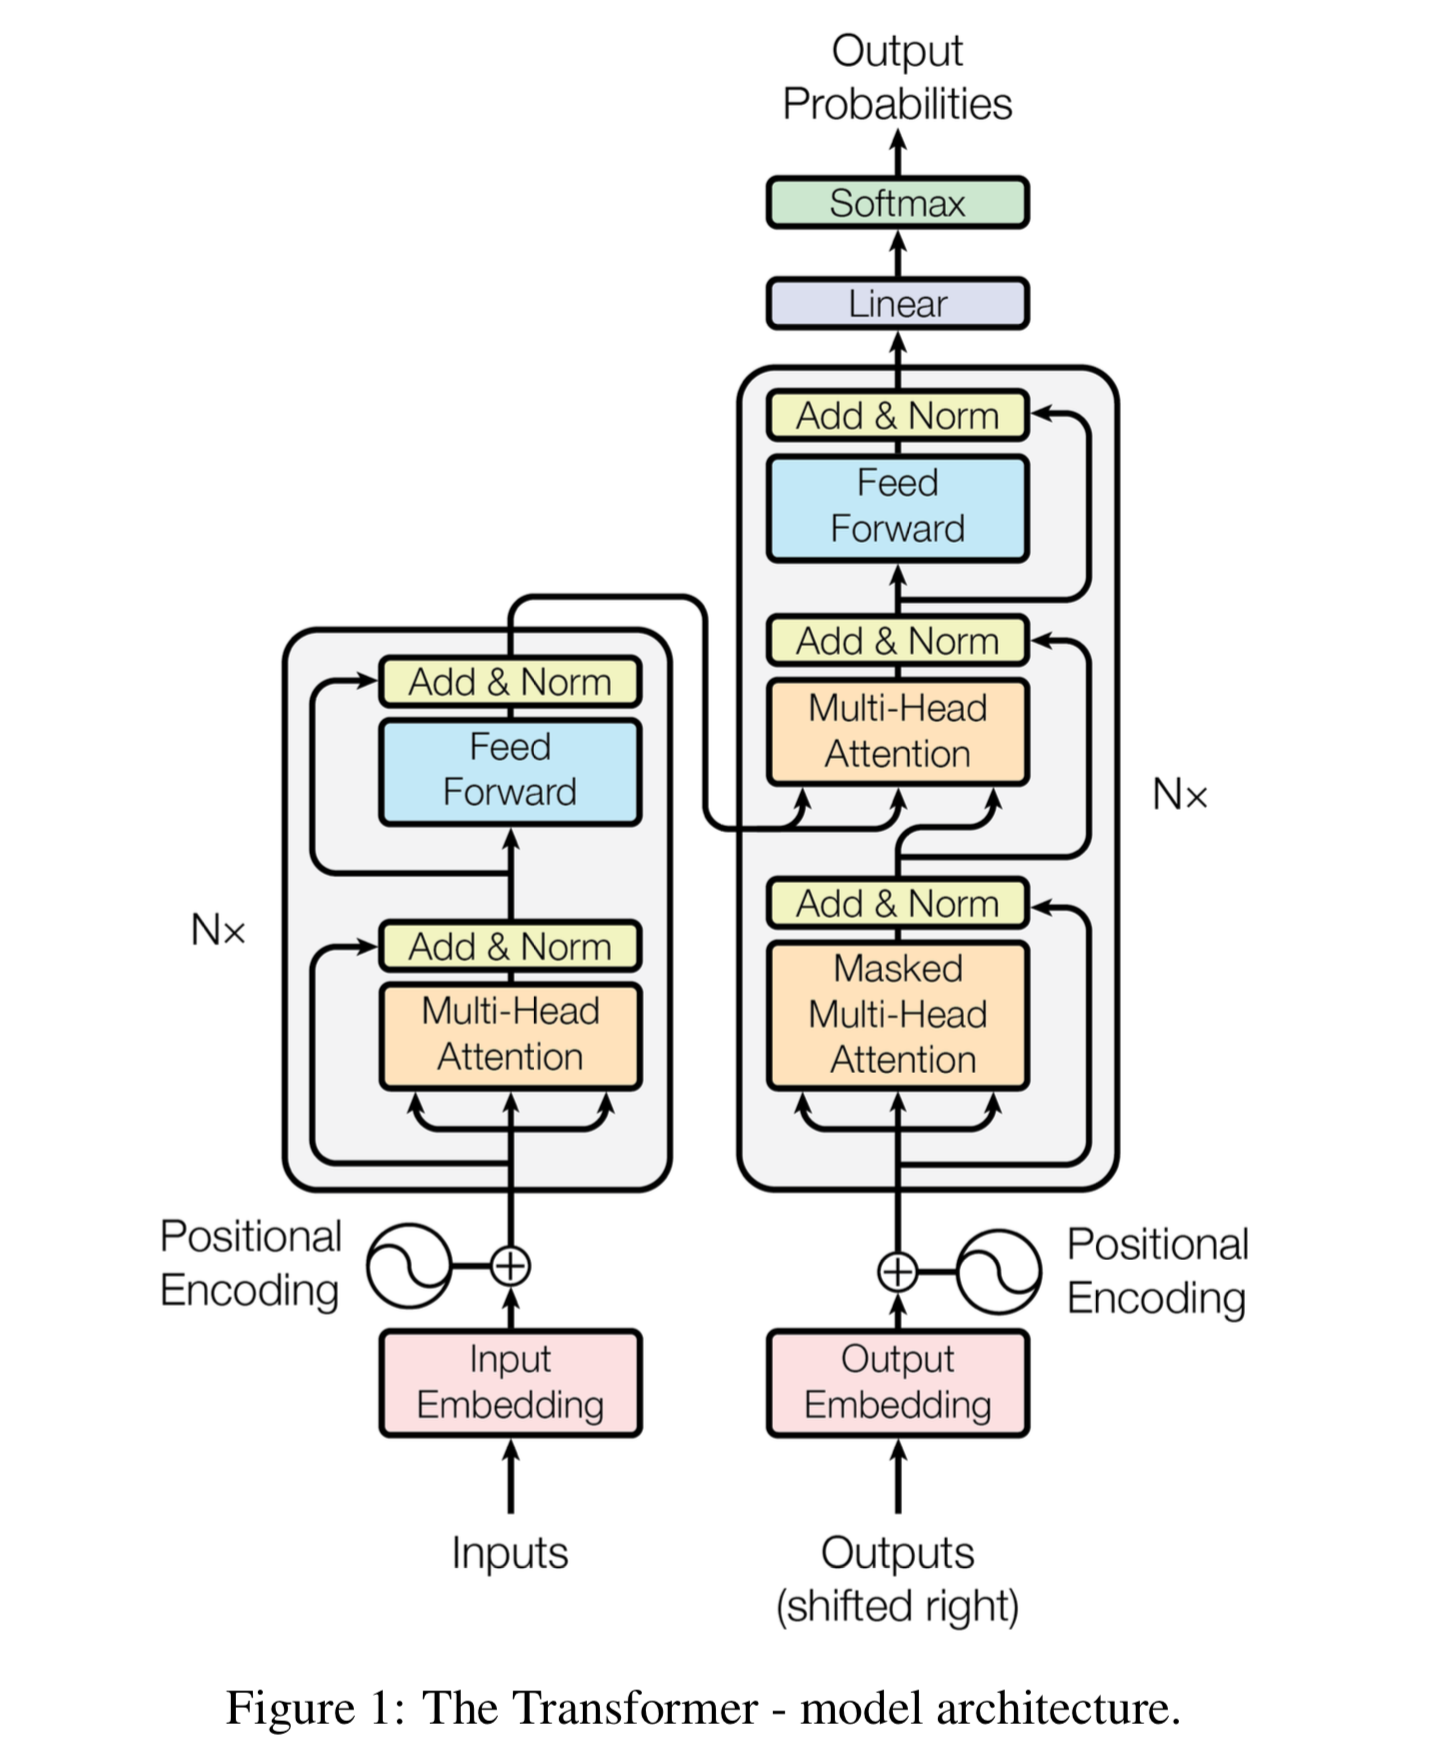



Left side of the architecture is the Encoder and it consists of: 
- An input of shape: `[batch_size, max_input_sentence_length]`.
- An output, a 512-dimensional word representation matrix, of shape: `[batch_size, max_input_sentence_length, 512]`.

Right side of the architecture is the Decoder and it consists of:
- The target sentence as input, as a sequence of word IDs which have been shifted one time step to the right. 
- Takes the outputs of the Encoder. 
- An output of shape: `[batch_size, max_output_sentence_length, vocab_length]`.

During inference, the Decoder is fed the output word starting with the start of sequence token. 

Interestingly, the individual components within the architecture are familiar however the 2 Multi-Head Attention layers allows the model to focus on the relationship with every other word within the sentence and the most relevant word within the input sentence. This is called self-attention.

As the Multi-Head attention layer only looks at the relationship of a word within a sentence, the positional embeddings allows the model to gain access to each word's position. 

### Positional Embeddings

Positional Embeddings are dense vectors that encode position of a word within a sentence. A great video explaining how it works is [here](https://www.youtube.com/watch?v=dichIcUZfOw).

As mentioned, the Multi-Head layer does not consider the position of the word within the sentence. The authors added positional information in through Positional Embeddings. They used $\sin$ and $\cos$, $i^{th}$ component of the embedding, and the dimension of the embedding itself (i.e. 512). 

This allows the positional embeddings to be useful during long sentence translations. 

### Multi-Head Attention

Multi-head Attention layer is based on the Scaled Dot Product Attention layer. In short you can think of it as a differentiable dictionary lookup that attempts to learn whether a word is a verb, subject, noun etc. but remember that each word is represented as a vector (learned during training).

As mentioned, the encoder represents the words as vectors. Suppose the decoder already has translated the beginning of a sentence, it will now look for the next logical word to translate. For example, "They played tennis", the decoder translates the subject "They" and now looks for the verb based on its vectorized representation, called a query. The query and the key to the word (i.e. the encoder's representation) are compared and similiarity measure is used. 

Having multiple of these types of layers allows the model to represent a word into different subspaces. All information about the word is split across the layers such as whether the word is a verb, past tense, etc.. 

`Tensorflow` has several Transformer based architectures!


# Future and Progress in NLP

The future of NLP is bright! The idea of Transformers has dropped the error rate to NMT tasks as well as other tasks such as Next Sentence Prediction (NSP) and Masked Language Model (MLM). The Bidirectional Encoder Representation from Transformers (BERT) model is beginning to gain traction because it demonstrated the effectiveness of self-supervised pretraining on a large corpus. The models are becoming larger with more parameters, for example, GPT-2 with over 1.5 billion! 

I wouldn't be surprised if LSTMs, RNN or CNN make a comeback, or even a combination of all of them alongside a Transformer architecture. Natural Language processing tasks are still developing and they will continue to do so! 
